In [1]:
import scipy.stats as scs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import auc, roc_curve, classification_report,precision_recall_curve
import seaborn as sns
from dateutil.relativedelta import relativedelta
from lightgbm.sklearn import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction import DictVectorizer


from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from pdpbox import pdp, info_plots
seed = 42

/Users/dwight/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def roc_pr_curve_plot(trained_model, X_train, y_train, X_test, y_test):
    '''
    A customized visualization hanlder
    '''
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlim([-0.05,1.05])
    ax2.set_ylim([-0.05,1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')

    pred_prob = trained_model.predict_proba(X_train)[:,1]

    p_train,r_train,_ = precision_recall_curve(y_train,pred_prob)
    tpr_train,fpr_train,_ = roc_curve(y_train,pred_prob) 

    ax1.plot(r_train,p_train,c='r',label='train')
    ax2.plot(tpr_train,fpr_train,c='r',label='train')

    pred_prob = trained_model.predict_proba(X_test)[:,1]

    p_test,r_test,_ = precision_recall_curve(y_test,pred_prob)
    tpr_test,fpr_test,_ = roc_curve(y_test,pred_prob) 

    ax1.plot(r_test,p_test,c='b',label='test')
    ax2.plot(tpr_test,fpr_test,c='b',label='test')
    ax1.legend(loc='lower left')    
    ax2.legend(loc='lower left')
    return fig

In [3]:
df = pd.read_csv('data/predict_failure.csv')

In [4]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
df.shape

(124494, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [7]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [8]:
df['device'].nunique()

1168

In [9]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [10]:
print(df['date'].min())
print(df['date'].max())

2015-01-01 00:00:00
2015-11-02 00:00:00


In [11]:
df['month'] = df['date'].dt.month
df['dow'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dow'].apply(lambda x: 1 if x in [5, 6] else 0)

In [12]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [14]:
df['wom'] = df['date'].apply(week_of_month)

In [15]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9', 'month', 'dow', 'is_weekend', 'wom'],
      dtype='object')

<AxesSubplot:>

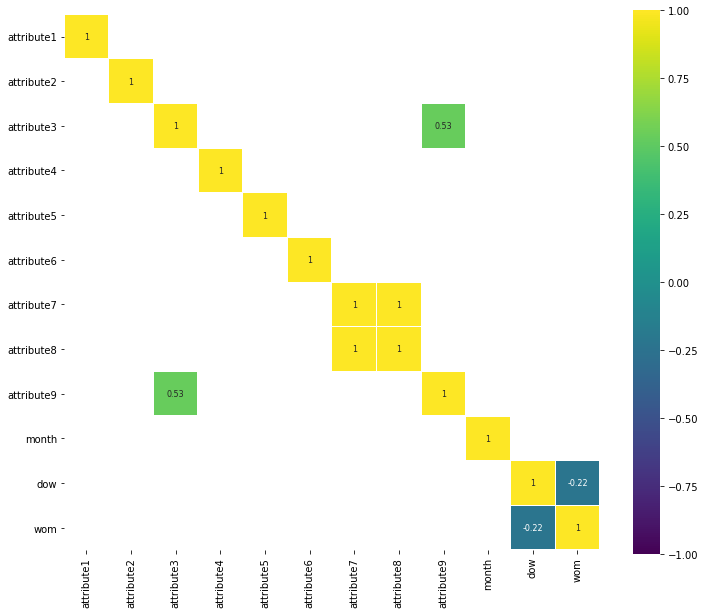

In [17]:
# Correlation heatmap
attr_lst = ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9', 'month', 'dow', 'wom']
corr = df[attr_lst].corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.2)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

In [18]:
# attribute7 and attribute8 are exactly the same, there fore we can remove one of them
df[df['attribute8'] != df['attribute7']]
df = df.drop('attribute8',1)

In [19]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'month', 'dow', 'is_weekend', 'wom'],
      dtype='object')

# seasonality check

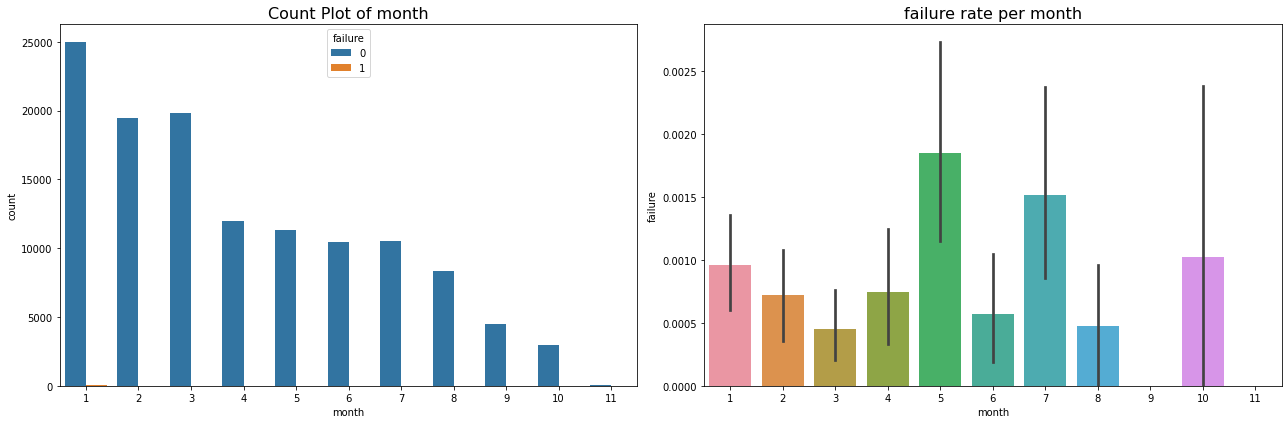

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='month', hue='failure', data=df, ax=ax[0])
ax[0].set_title('Count Plot of month', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='month', y='failure', data=df, ax=ax[1]);
ax[1].set_title('failure rate per month', fontsize=16)
plt.tight_layout()
plt.show()

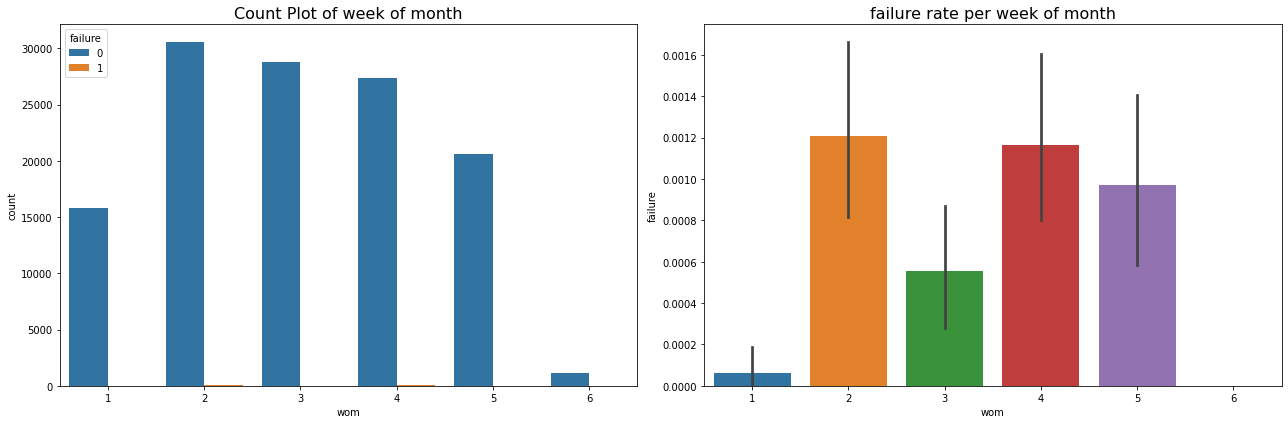

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='wom', hue='failure', data=df, ax=ax[0])
ax[0].set_title('Count Plot of week of month', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='wom', y='failure', data=df, ax=ax[1]);
ax[1].set_title('failure rate per week of month', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute9  124494 non-null  int64         
 11  month       124494 non-null  int64         
 12  dow         124494 non-null  int64         
 13  is_weekend  124494 non-null  int64         
 14  wom         124494 non-null  int64         
dtypes: datetime64[ns](1), int64(13), object(1)
memory u

In [24]:
need_cols = ['device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'month', 'dow', 'is_weekend']
feat_cols = ['device', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'month', 'dow', 'wom','is_weekend']
X = df[feat_cols]
y = df['failure']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [26]:
# train a lgbm model because 
# 1. this is imbalance dataset so boosting is a good way to handle it 
# 2. If there are many correlated features, tree model can handle 
# 3. We don't need to do feature scaling
# 4. If there are non linear relationship, tree model can handle it

In [27]:
v = DictVectorizer()
X_train = v.fit_transform(X_train.to_dict('records'))
X_test = v.transform(X_test.to_dict('records'))

In [28]:
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
lgbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

In [29]:
# we are interested in finding the failure case therefore PR curve is more suitable

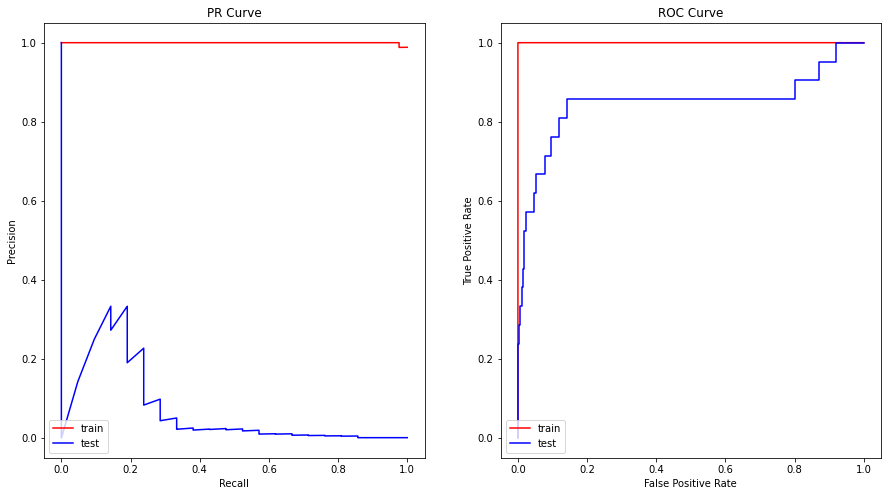

In [30]:
fig = roc_pr_curve_plot(lgbm,X_train,y_train,X_test,y_test)

In [31]:
for k_cols in [20,50,100,200,500,1000]:
    selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
    X_train_s = X_train[:,selectors.get_support()].copy()
    X_test_s = X_test[:,selectors.get_support()].copy()
    #X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
    lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
    lgbm.fit(X_train_s, y_train)
    pred = lgbm.predict_proba(X_test_s)[:,1]
    print(k_cols,average_precision_score(y_test,pred))

20 0.005159214654633399
50 0.017381091513945922
100 0.04358373092699847
200 0.04451247536049592
500 0.10605746260643426
1000 0.08127166155117466


In [26]:
# we interested in evaluating a model whehter can identify a failure case overall, therefore 'average precision score' is applied here

In [32]:
k_cols = 500
selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
X_train_s = X_train[:,selectors.get_support()].copy()
X_test_s = X_test[:,selectors.get_support()].copy()
#X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
lgbm.fit(X_train_s, y_train)
pred = lgbm.predict_proba(X_test_s)[:,1]
print(k_cols,average_precision_score(y_test,pred))

500 0.10605746260643426


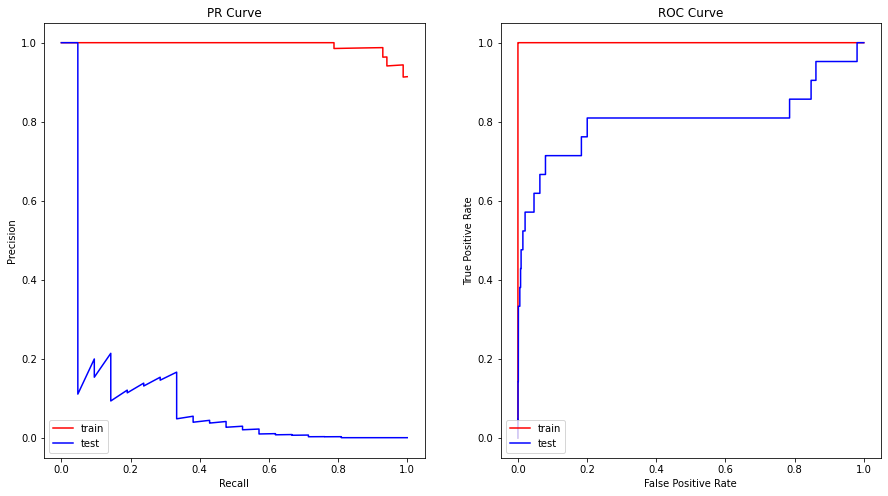

In [33]:
fig = roc_pr_curve_plot(lgbm,X_train_s,y_train,X_test_s,y_test)

In [34]:
cus_params = {'max_depth': 10, 'min_child_samples': 30, 'num_leaves': 20}
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed,**cus_params)
lgbm.fit(X_train_s,y_train)

LGBMClassifier(class_weight='balanced', max_depth=10, min_child_samples=30,
               num_leaves=20, random_state=42)

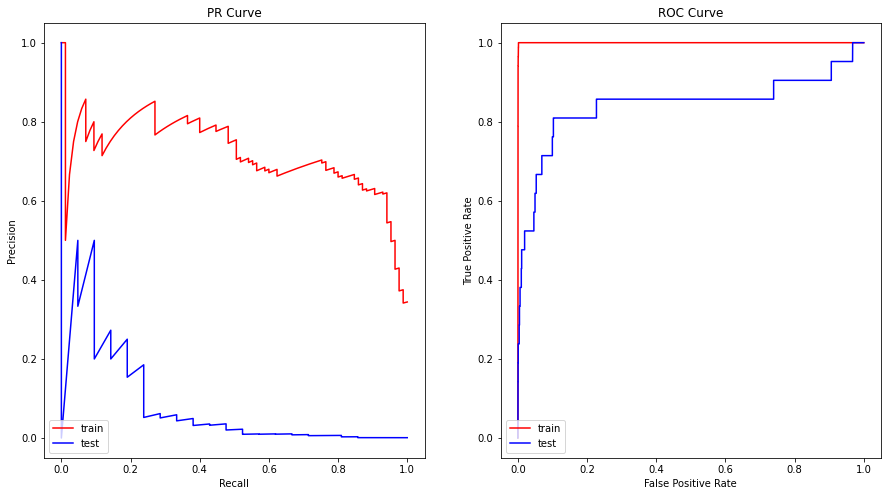

In [35]:
fig = roc_pr_curve_plot(lgbm,X_train_s,y_train,X_test_s,y_test)

In [36]:
pred = lgbm.predict(X_test_s)
print(classification_report(y_test,pred))
pred = lgbm.predict_proba(X_test_s)[:,1]
print('average precision score: ',average_precision_score(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     24878
           1       0.04      0.38      0.06        21

    accuracy                           0.99     24899
   macro avg       0.52      0.69      0.53     24899
weighted avg       1.00      0.99      0.99     24899

average precision score:  0.09669838673620192


In [37]:
model = LGBMClassifier(class_weight='balanced',random_state=seed)
params_opt = {'num_leaves':[5, 10, 15, 20], 
            'max_depth':[5, 10, 15, 20],
            'min_child_samples': [10, 20, 30, 40]}
gridSearchCV = GridSearchCV(estimator = model, 
                            param_grid = params_opt, 
                            scoring='average_precision',
                            n_jobs=-1, 
                            verbose=1,
                            cv=5)
gridSearchCV.fit(X_train_s,y_train)
print('best_params: ',gridSearchCV.best_params_)
print('best_average_precision_score',gridSearchCV.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
best_params:  {'max_depth': 10, 'min_child_samples': 10, 'num_leaves': 10}
best_average_precision_score 0.0743441397748078


In [32]:
model = LGBMClassifier(class_weight='balanced',random_state=seed)
params_opt = {'num_leaves':[5, 10, 15, 20], 
            'max_depth':[5, 10, 15, 20],
            'min_child_samples': [10, 20, 30, 40]}
gridSearchCV = GridSearchCV(estimator = model, 
                            param_grid = params_opt, 
                            scoring='average_precision',
                            n_jobs=-1, 
                            verbose=1,
                            cv=5)
gridSearchCV.fit(X_train_s,y_train)
print('best_params: ',gridSearchCV.best_params_)
print('best_average_precision_score',gridSearchCV.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
best_params:  {'max_depth': 5, 'min_child_samples': 40, 'num_leaves': 5}
best_average_precision_score 0.07667629301611714


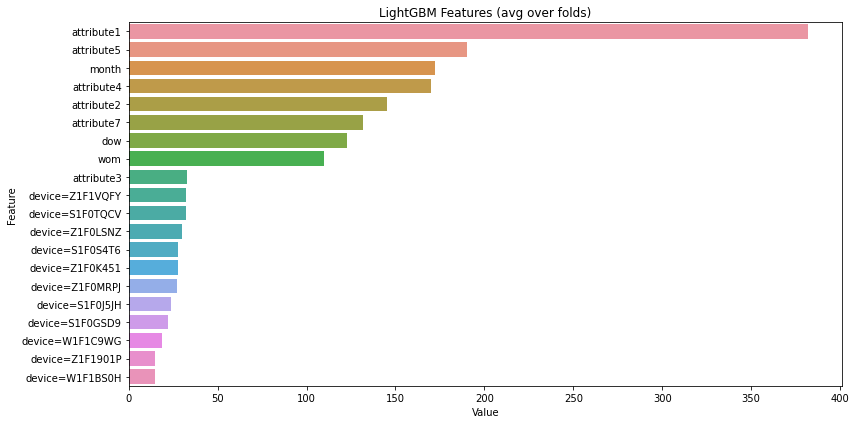

In [38]:
whole_feature_cols = np.array(v.get_feature_names())
selected_feature_cols = whole_feature_cols[selectors.get_support()]
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, selected_feature_cols)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
#b.set_yticklabels(b.get_yticks(), size = 15)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

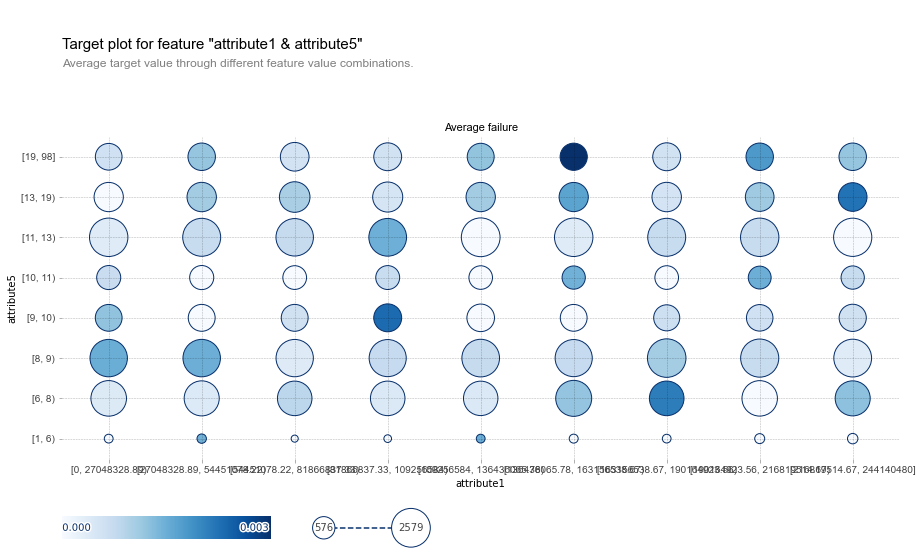

In [39]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df, features=['attribute1', 'attribute5'], feature_names=['attribute1', 'attribute5'], target='failure'
)

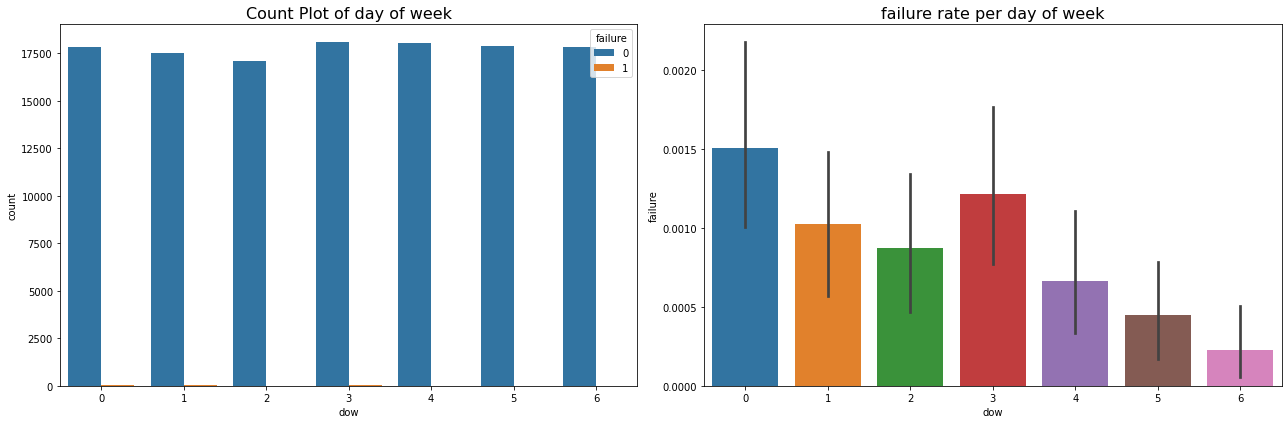

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='dow', hue='failure', data=df, ax=ax[0])
ax[0].set_title('Count Plot of day of week', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='dow', y='failure', data=df, ax=ax[1]);
ax[1].set_title('failure rate per day of week', fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
df['device_title'] = df['device'].str[:2]
df['device_second_title'] = df['device'].str[2:4]

In [43]:
feat_cols = ['device', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'month', 'dow', 'wom', 'is_weekend', 'device_title', 'device_second_title']
X = df[feat_cols]
y = df['failure']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [45]:
v = DictVectorizer()
X_train = v.fit_transform(X_train.to_dict('records'))
X_test = v.transform(X_test.to_dict('records'))

In [46]:
best_k = 0
best_score = 0
for k_cols in [20,50,100,200,500,1000]:
    selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
    X_train_s = X_train[:,selectors.get_support()].copy()
    X_test_s = X_test[:,selectors.get_support()].copy()
    #X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
    lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
    lgbm.fit(X_train_s, y_train)
    pred = lgbm.predict_proba(X_test_s)[:,1]
    score = average_precision_score(y_test,pred)
    if score > best_score:
        best_score = score
        best_k = k_cols
        best_selectors = selectors
    print(k_cols,average_precision_score(y_test,pred))

20 0.005159214654633399
50 0.017381091513945922
100 0.05793350174067361
200 0.07422383112157668
500 0.06301031039915507
1000 0.16232978130747738


In [41]:
# we choose 100 because it has higher average precision score and less feature is relative better and easier to handle, save space

In [47]:
k_cols = 1000
selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
X_train_s = X_train[:,selectors.get_support()].copy()
X_test_s = X_test[:,selectors.get_support()].copy()
#X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
lgbm.fit(X_train_s, y_train)
pred = lgbm.predict_proba(X_test_s)[:,1]
print(k_cols,average_precision_score(y_test,pred))

1000 0.16232978130747738


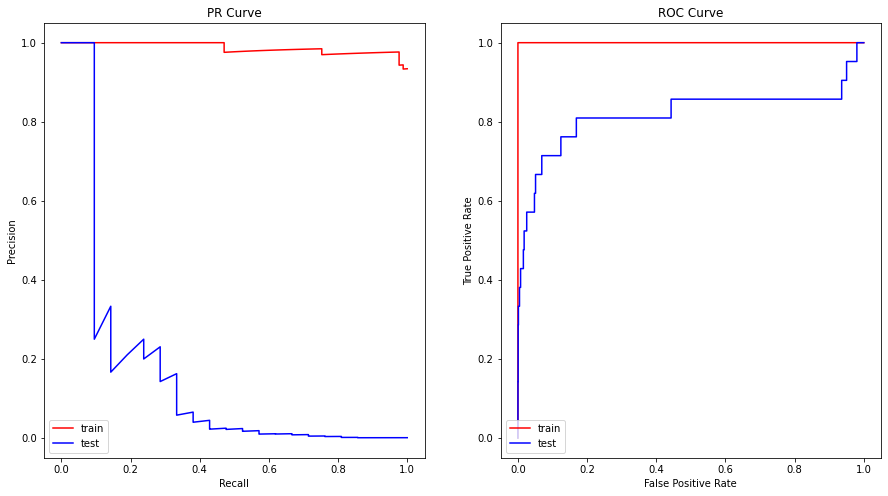

In [48]:
fig = roc_pr_curve_plot(lgbm,X_train_s,y_train,X_test_s,y_test)

In [49]:
model = LGBMClassifier(class_weight='balanced',random_state=seed)
params_opt = {'num_leaves':[3,5, 10, 15, 20], 
            'max_depth':[3,5, 10, 15, 20],
            'min_child_samples': [10, 20, 30, 40, 50]}
gridSearchCV = GridSearchCV(estimator = model, 
                            param_grid = params_opt, 
                            scoring='average_precision',
                            n_jobs=-1, 
                            verbose=1,
                            cv=5)
gridSearchCV.fit(X_train_s,y_train)
print('best_params: ',gridSearchCV.best_params_)
print('best_average_precision_score',gridSearchCV.best_score_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
best_params:  {'max_depth': 3, 'min_child_samples': 20, 'num_leaves': 5}
best_average_precision_score 0.08695610893567671


In [44]:
model = LGBMClassifier(class_weight='balanced',random_state=seed)
params_opt = {'num_leaves':[3,5, 10, 15, 20], 
            'max_depth':[3,5, 10, 15, 20],
            'min_child_samples': [10, 20, 30, 40, 50]}
gridSearchCV = GridSearchCV(estimator = model, 
                            param_grid = params_opt, 
                            scoring='average_precision',
                            n_jobs=-1, 
                            verbose=1,
                            cv=5)
gridSearchCV.fit(X_train_s,y_train)
print('best_params: ',gridSearchCV.best_params_)
print('best_average_precision_score',gridSearchCV.best_score_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
best_params:  {'max_depth': 5, 'min_child_samples': 40, 'num_leaves': 5}
best_average_precision_score 0.08483885716390697


In [50]:
best_params = gridSearchCV.best_params_
print('best paramaters: ', best_params)
print('best average precision score: ',gridSearchCV.best_score_)

best paramaters:  {'max_depth': 3, 'min_child_samples': 20, 'num_leaves': 5}
best average precision score:  0.08695610893567671


In [51]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=seed, **best_params)
lgbm.fit(X_train_s, y_train)

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=5,
               random_state=42)

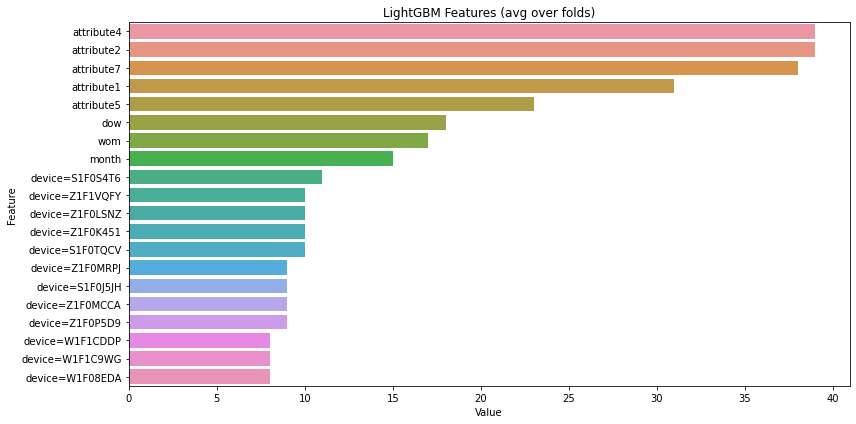

In [52]:
whole_feature_cols = np.array(v.get_feature_names())
selected_feature_cols = whole_feature_cols[selectors.get_support()]
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, selected_feature_cols)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
#b.set_yticklabels(b.get_yticks(), size = 15)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [53]:
df['device_title'].unique()

array(['S1', 'W1', 'Z1'], dtype=object)

In [54]:
df['device_second_title'].unique()

array(['F0', 'F1', 'F2'], dtype=object)

<AxesSubplot:xlabel='device_title', ylabel='count'>

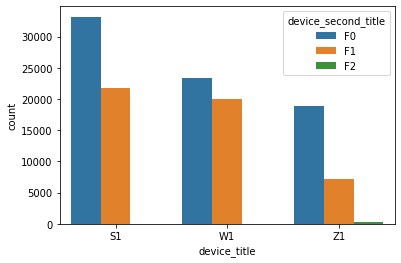

In [55]:
sns.countplot(x="device_title", hue="device_second_title", data=df)

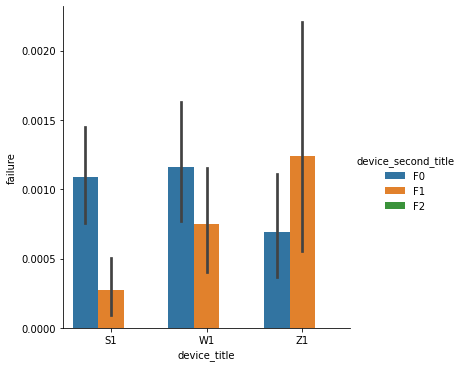

In [56]:
sns.catplot(x="device_title", y="failure", hue="device_second_title", kind="bar", data=df)

In [52]:
test = pd.read_csv('data/predict_failure.csv')

In [53]:
test = test.sample(frac=0.1)

In [54]:
## feature engineerin and proces data
def process_df(df, need_cols):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
    df['month'] = df['date'].dt.month
    df['dow'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dow'].apply(lambda x: 1 if x in [5, 6] else 0)
    df = df.drop('attribute8',1)
    df['device_title'] = df['device'].str[:2]
    df['device_second_title'] = df['device'].str[2:4]
    return df[need_cols]
feat_cols = ['device', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'month', 'dow', 'is_weekend', 'device_title', 'device_second_title']
test_X = process_df(test, feat_cols)

In [55]:
test_X = v.transform(test_X.to_dict('records'))
test_X_select = test_X[:,selectors.get_support()].copy()

In [56]:
pred = lgbm.predict(test_X_select)

In [57]:
test['predict_score'] = pred